## Install Dependencies

In [1]:
%pip install matplotlib

import numpy as np
from matplotlib import pyplot as plt
from statistics import mean


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Load result data

In [2]:
import json 

with open("experiment_results.json", "r") as results_file:
    experiments = json.load(results_file)

In [3]:
available_tags = set([
    experiment["params"]["tag"] for experiment in experiments
])
print("available tags:", available_tags)

available tags: {'varying_qubits', 'varying_redundancy', 'varying_gates', 'reordering_varying_redundancy', 'reordering_varying_steps'}


## RQ1: How does the degree of redundancy within a population influence the behavior of the proposed simulation approach?

In [4]:
# Filter out and format experiment results with the varying_redundancy tag

vr_experiments = [experiment for experiment in experiments if experiment["params"]["tag"] == "varying_redundancy"]
print(f"Total amount of varying_redundancy experiments: {len(vr_experiments)}")

Total amount of varying_redundancy experiments: 80


In [5]:
redundancies = [experiment["params"]["redundancy"] for experiment in vr_experiments]
redundancies = list(set(redundancies))
redundancies.sort()

print("Redundancies:", redundancies)

Redundancies: [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]


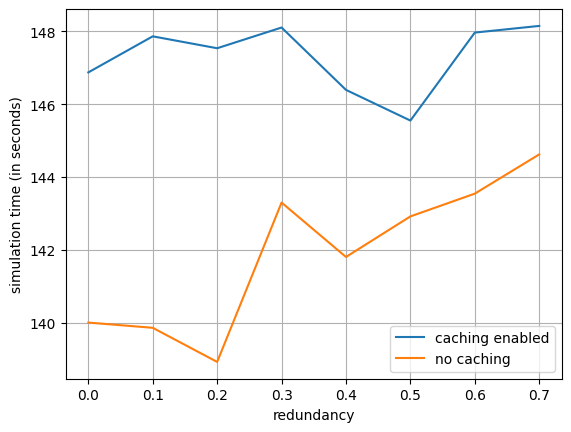

In [6]:
# Create a line chart with simulation time on y and redundancy level
# on x. One line for the runs with caching enabled, one line for the
# runs with cache size 0.

durations_no_cache = []
durations_with_cache = []

for redundancy in redundancies:

    sel_durations_no_cache = [
        experiment["total_duration"]
        for experiment in vr_experiments
        if experiment["params"]["cache_size"] == 0
        and experiment["params"]["redundancy"] == redundancy
    ]
    durations_no_cache.append(mean(sel_durations_no_cache))

    sel_durations_with_cache = [
        experiment["total_duration"]
        for experiment in vr_experiments
        if experiment["params"]["cache_size"] > 0
        and experiment["params"]["redundancy"] == redundancy
    ]
    durations_with_cache.append(mean(sel_durations_with_cache))


ax = plt.subplot()
ax.plot(redundancies, durations_with_cache)
ax.set_xlabel("redundancy")
ax.set_ylabel("simulation time (in seconds)")

ax = plt.subplot()
ax.plot(redundancies, durations_no_cache)
ax.set_xlabel("redundancy")
ax.set_ylabel("simulation time (in seconds)")


plt.legend(["caching enabled", "no caching"])
plt.grid()
plt.show()

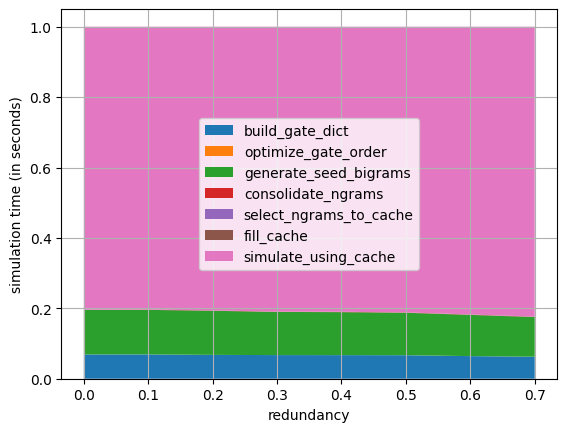

In [7]:
# Create a stack chart of the durations of different algorithm steps
# for all runs where cache size = 100.

build_gate_dict_durations = []
optimize_gate_order_durations = []
generate_seed_bigrams_durations = []
consolidate_ngrams_durations = []
select_ngrams_to_cache_durations = []
fill_cache_durations = []
simulate_using_cache_durations = []

for redundancy in redundancies:

    relevant_experiments = [
        experiment
        for experiment in vr_experiments
        if experiment["params"]["cache_size"] == 100
        and experiment["params"]["redundancy"] == redundancy
    ]

    total_duration = mean(
        [experiment["total_duration"] for experiment in relevant_experiments]
    )

    build_gate_dict_durations.append(
        mean(
            [
                experiment["build_gate_frequency_dict"]["duration"]
                for experiment in relevant_experiments
            ]
        ) / total_duration
    )
    optimize_gate_order_durations.append(
        mean(
            [
                experiment["optimize_gate_order"]["duration"]
                for experiment in relevant_experiments
            ]
        ) / total_duration
    )
    generate_seed_bigrams_durations.append(
        mean(
            [
                experiment["generate_seed_bigrams"]["duration"]
                for experiment in relevant_experiments
            ]
        ) / total_duration
    )
    consolidate_ngrams_durations.append(
        mean(
            [
                experiment["consolidate_ngrams"]["duration"]
                for experiment in relevant_experiments
            ]
        ) / total_duration
    )
    select_ngrams_to_cache_durations.append(
        mean(
            [
                experiment["select_ngrams_to_cache"]["duration"]
                for experiment in relevant_experiments
            ]
        ) / total_duration
    )
    fill_cache_durations.append(
        mean(
            [
                experiment["fill_cache"]["duration"]
                for experiment in relevant_experiments
            ]
        ) / total_duration
    )
    simulate_using_cache_durations.append(
        mean(
            [
                experiment["simulate_using_cache"]["duration"]
                for experiment in relevant_experiments
            ]
        ) / total_duration
    )

x = redundancies
y = np.vstack(
    [
        build_gate_dict_durations,
        optimize_gate_order_durations,
        generate_seed_bigrams_durations,
        consolidate_ngrams_durations,
        select_ngrams_to_cache_durations,
        fill_cache_durations,
        simulate_using_cache_durations,
    ],
)

fig, ax = plt.subplots()

ax.stackplot(x, y)
ax.set_xlabel("redundancy")
ax.set_ylabel("simulation time (in seconds)")

plt.legend(
    [
        "build_gate_dict",
        "optimize_gate_order",
        "generate_seed_bigrams",
        "consolidate_ngrams",
        "select_ngrams_to_cache",
        "fill_cache",
        "simulate_using_cache",
    ]
)
plt.grid()

plt.show()

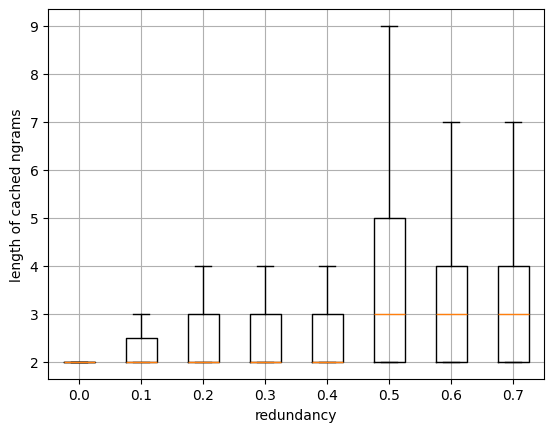

In [26]:
# Create box plots for sequence lengths of cached ngrams
# at different redundancy levels.

sequence_lengths = []

for redundancy in redundancies:

    relevant_experiments = [
        experiment for experiment in vr_experiments if 
        experiment["params"]["cache_size"] == 100 and experiment["params"]["redundancy"] == redundancy
    ]

    relevant_sequence_lengths = []
    for experiment in relevant_experiments:
        relevant_sequence_lengths.extend(experiment["fill_cache"]["ngram_lengths"])


    sequence_lengths.append(relevant_sequence_lengths)

fig, ax = plt.subplots()

ax.boxplot(sequence_lengths, showfliers=False)
ax.set_xlabel("redundancy")
ax.set_ylabel("length of cached ngrams")

plt.xticks([i + 1 for i in range(len(redundancies))], redundancies)

plt.grid()
plt.show()



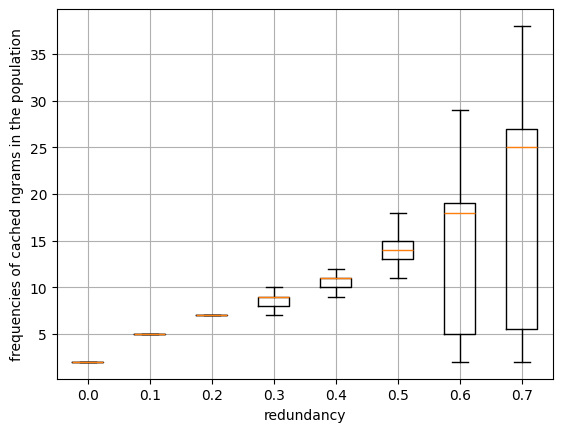

In [27]:
# Create box plots for frequency of cached ngrams at different redundancy levels.

frequencies = []

for redundancy in redundancies:

    relevant_experiments = [
        experiment for experiment in vr_experiments if 
        experiment["params"]["cache_size"] == 100 and experiment["params"]["redundancy"] == redundancy
    ]

    relevant_frequencies = []
    for experiment in relevant_experiments:
        relevant_frequencies.extend(experiment["fill_cache"]["ngram_frequencies"])


    frequencies.append(relevant_frequencies)

fig, ax = plt.subplots()

ax.boxplot(frequencies, showfliers=False)
ax.set_xlabel("redundancy")
ax.set_ylabel("frequencies of cached ngrams in the population")

plt.xticks([i + 1 for i in range(len(redundancies))], redundancies)

plt.grid()
plt.show()

## RQ2.1: How does the amount of qubits in the population influence simulation speed?

In [10]:
# Filter out and format experiment results with the varying_qubits tag

vq_experiments = [experiment for experiment in experiments if experiment["params"]["tag"] == "varying_qubits"]
print(f"Total amount of varying_qubits experiments: {len(vq_experiments)}")

Total amount of varying_qubits experiments: 60


In [11]:
qubit_nums = [experiment["params"]["qubit_num"] for experiment in vq_experiments]
qubit_nums = list(set(qubit_nums))
qubit_nums.sort()

print("Qubit counts:", qubit_nums)

Qubit counts: [3, 4, 5, 6, 7, 8]


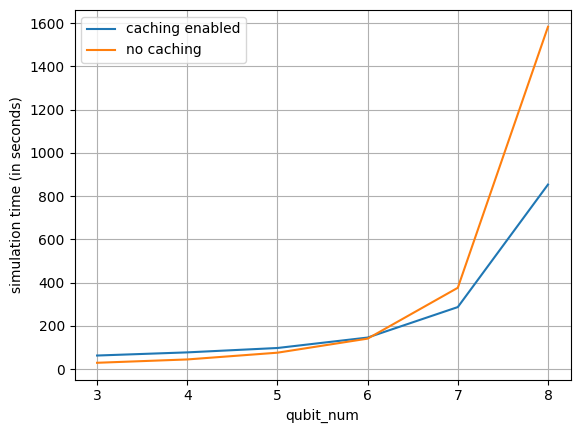

In [12]:
# Create a line chart with simulation time on y and qubit count 
# on x. One line for the runs with caching enabled, one line for the 
# runs with cache size 0.

durations_no_cache = []
durations_with_cache = []

for qubit_num in qubit_nums:

    sel_durations_no_cache = [
        experiment["total_duration"]
        for experiment in vq_experiments
        if experiment["params"]["cache_size"] == 0
        and experiment["params"]["qubit_num"] == qubit_num
    ]
    durations_no_cache.append(mean(sel_durations_no_cache))

    sel_durations_with_cache = [
        experiment["total_duration"]
        for experiment in vq_experiments
        if experiment["params"]["cache_size"] > 0
        and experiment["params"]["qubit_num"] == qubit_num
    ]
    durations_with_cache.append(mean(sel_durations_with_cache))

ax = plt.subplot()
ax.plot(qubit_nums, durations_with_cache)
ax.set_xlabel("qubit_num")
ax.set_ylabel("simulation time (in seconds)")

ax = plt.subplot()
ax.plot(qubit_nums, durations_no_cache)
ax.set_xlabel("qubit_num")
ax.set_ylabel("simulation time (in seconds)")


plt.legend(["caching enabled", "no caching"])
plt.grid()
plt.show()


## RQ2.2: How does the amount of gates per circuit influence simulation speed?

In [13]:
# Filter out and format experiment results with the varying_gates tag

vg_experiments = [experiment for experiment in experiments if experiment["params"]["tag"] == "varying_gates"]
print(f"Total amount of varying_gates experiments: {len(vg_experiments)}")

Total amount of varying_gates experiments: 100


In [14]:
gate_counts = [experiment["params"]["gate_count"] for experiment in vg_experiments]
gate_counts = list(set(gate_counts))
gate_counts.sort()

print("Gate counts:", gate_counts)

Gate counts: [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]


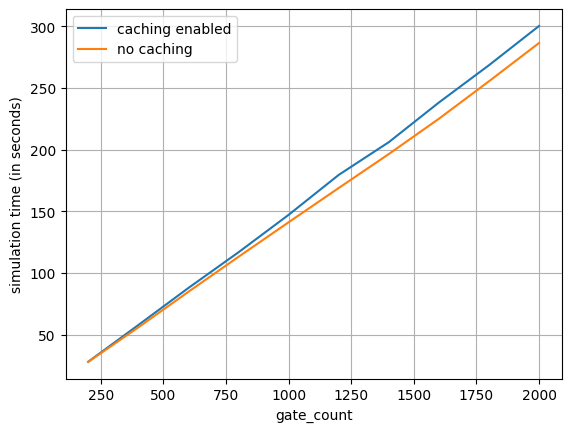

In [15]:
# Create a line chart with simulation time on y and gate count per circuit 
# on x. One line for the runs with caching enabled, one line for the 
# runs with cache size 0.

durations_no_cache = []
durations_with_cache = []

for gate_count in gate_counts:

    sel_durations_no_cache = [
        experiment["total_duration"]
        for experiment in vg_experiments
        if experiment["params"]["cache_size"] == 0
        and experiment["params"]["gate_count"] == gate_count
    ]
    durations_no_cache.append(mean(sel_durations_no_cache))

    sel_durations_with_cache = [
        experiment["total_duration"]
        for experiment in vg_experiments
        if experiment["params"]["cache_size"] > 0
        and experiment["params"]["gate_count"] == gate_count
    ]
    durations_with_cache.append(mean(sel_durations_with_cache))

ax = plt.subplot()
ax.plot(gate_counts, durations_with_cache)
ax.set_xlabel("gate_count")
ax.set_ylabel("simulation time (in seconds)")

ax = plt.subplot()
ax.plot(gate_counts, durations_no_cache)
ax.set_xlabel("gate_count")
ax.set_ylabel("simulation time (in seconds)")


plt.legend(["caching enabled", "no caching"])
plt.grid()
plt.show()


## RQ3.1: How does the amount of reordering steps influence simulation speed?

In [16]:
# Filter out and format experiment results with the reordering_varying_steps tag

rvs_experiments = [experiment for experiment in experiments if experiment["params"]["tag"] == "reordering_varying_steps"]
print(f"Total amount of reordering_varying_steps experiments: {len(rvs_experiments)}")

Total amount of reordering_varying_steps experiments: 55


In [17]:
reordering_steps = [experiment["params"]["reordering_steps"] for experiment in rvs_experiments]
reordering_steps = list(set(reordering_steps))
reordering_steps.sort()

print("Reordering steps:", reordering_steps)

Reordering steps: [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


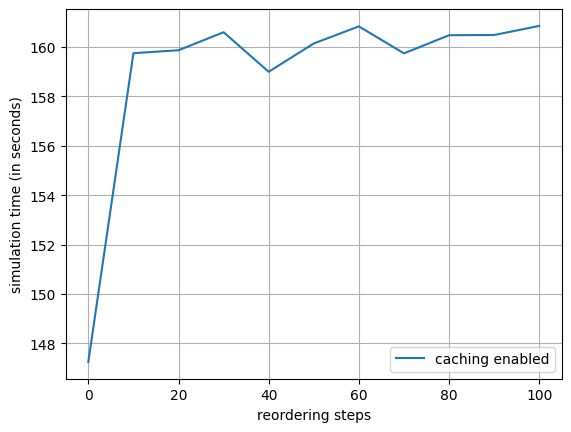

In [18]:
# Create a line chart with simulation time on y and reordering step count 
# on x. 

durations_with_cache = []

for reordering_step in reordering_steps:

    sel_durations_with_cache = [
        experiment["total_duration"]
        for experiment in rvs_experiments
        if experiment["params"]["cache_size"] > 0
        and experiment["params"]["reordering_steps"] == reordering_step
    ]
    durations_with_cache.append(mean(sel_durations_with_cache))

ax = plt.subplot()
ax.plot(reordering_steps, durations_with_cache)
ax.set_xlabel("reordering steps")
ax.set_ylabel("simulation time (in seconds)")


plt.legend(["caching enabled"])
plt.grid()
plt.show()


## RQ3.2: How does the amount of reordering steps influence the lengths and frequencies of the cached gate sequences across varying redundancy levels?

In [19]:
# Filter out and format experiment results with the reordering_varying_redundancy tag

rvr_experiments = [experiment for experiment in experiments if experiment["params"]["tag"] == "reordering_varying_redundancy"]
print(f"Total amount of reordering_varying_redundancy experiments: {len(rvr_experiments)}")

Total amount of reordering_varying_redundancy experiments: 40


In [20]:
redundancies = [experiment["params"]["redundancy"] for experiment in rvr_experiments]
redundancies = list(set(redundancies))
redundancies.sort()

print("Redundancies:", redundancies)

Redundancies: [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]


In [21]:
# TBD: How to best visualize change in redundancy depending on starting redundancy

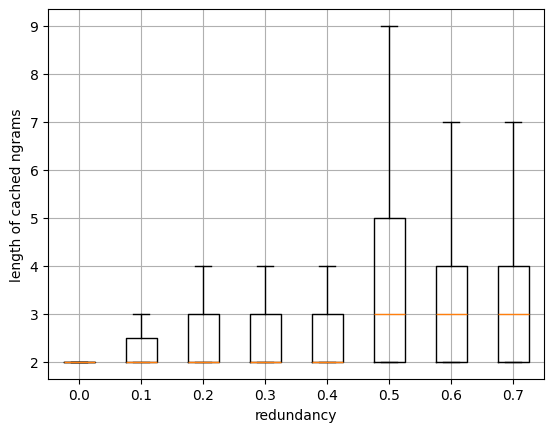

In [28]:
# Create box plots for sequence length of cached ngrams
# at different reordering step counts.

sequence_lengths = []

for redundancy in redundancies:

    relevant_experiments = [
        experiment for experiment in rvr_experiments if 
        experiment["params"]["cache_size"] == 100 and experiment["params"]["redundancy"] == redundancy
    ]

    relevant_sequence_lengths = []
    for experiment in relevant_experiments:
        relevant_sequence_lengths.extend(experiment["fill_cache"]["ngram_lengths"])


    sequence_lengths.append(relevant_sequence_lengths)

fig, ax = plt.subplots()

ax.boxplot(sequence_lengths, showfliers=False)
ax.set_xlabel("redundancy")
ax.set_ylabel("length of cached ngrams")

plt.xticks([i + 1 for i in range(len(redundancies))], redundancies)

plt.grid()
plt.show()

In [23]:
# Create box plots for the frequency of cached ngrams
# at different reordering step counts.